### Delivery Duration Prediction_ DoorDash


#### Content
This task involves building a model to predict the estimated time taken for a delivery when a consumer places an order on DoorDash. The accuracy of this prediction is crucial for ensuring a positive consumer experience. Therefore, it is important to develop a reliable model that can help DoorDash estimate delivery times accurately. Additionally, you will analyze the model's performance and answer some related questions.

NB: for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from


#### Feature description

- market_id:  geographic market or location where the order was placed
- created_at/ start:  date and time the order submitted by the customers
- actual_delivery_time/ end:  actual time the delivery was completed
- store_id:  unique identifier for the restaurant/store that fulfilled the order
- store_primary_category:  main category or cuisine type of the restaurant or store
- order_protocol:  order fulfillment method or protocol used by the restaurant or store
- total_items:  total number of items ordered
- subtotal:  total cost of the order before any fees or taxes
- num_distinct_items:  number of distinct or unique items ordered
- min_item_price:  price of the cheapest item in the order
- max_item_price:  price of the most expensive item in the order
- total_onshift_dashers:  total number of delivery drivers who were on shift at the time the order
- total_busy_dashers: number of delivery drivers who were currently busy with other orders when the order
- total_outstanding_orders:  total number of orders that were still outstanding and waiting to be delivered at the time the order
- estimated_order_place_duration:  estimated time it will take the restaurant or store to prepare the order
- estimated_store_to_consumer_driving_duration:  estimated time it will take the delivery driver to travel from the restaurant or store to the customer's location to deliver the order

#### Packages and Datasets

In [1]:
## import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta as td
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer 
from sklearn.impute import KNNImputer
from matplotlib import cm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
## get the the datasets 
def get_doordash(file_name ='DoorDash_data.csv'):
    df = pd.read_csv(file_name)
    return df
df = get_doordash() 
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


#### Exploratory Data Analysis (EDA)

##### Data quality
        Involves checking for missing values, outliers, incorrect data types, and data inconsistencies

In [3]:
# Check data types
print(df.info()) ## Checking for incorrect data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [129]:
df.describe() ## Dataset summary

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


-  what is the negative value in the min values

Negative values in the total_onshift_dashers column, it could be due to data entry errors or other issues with the data collection process. It is also possible that negative values in this column could be legitimate, depending on how the data is defined.

For example, if total_onshift_dashers represents the total number of DoorDash delivery drivers currently on shift in a particular area, it may be possible for this number to go negative if there are more drivers than available orders, resulting in drivers being sent home early. However, it would be unusual for this to occur frequently or for the negative values to be large in magnitude.

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


<Axes: >

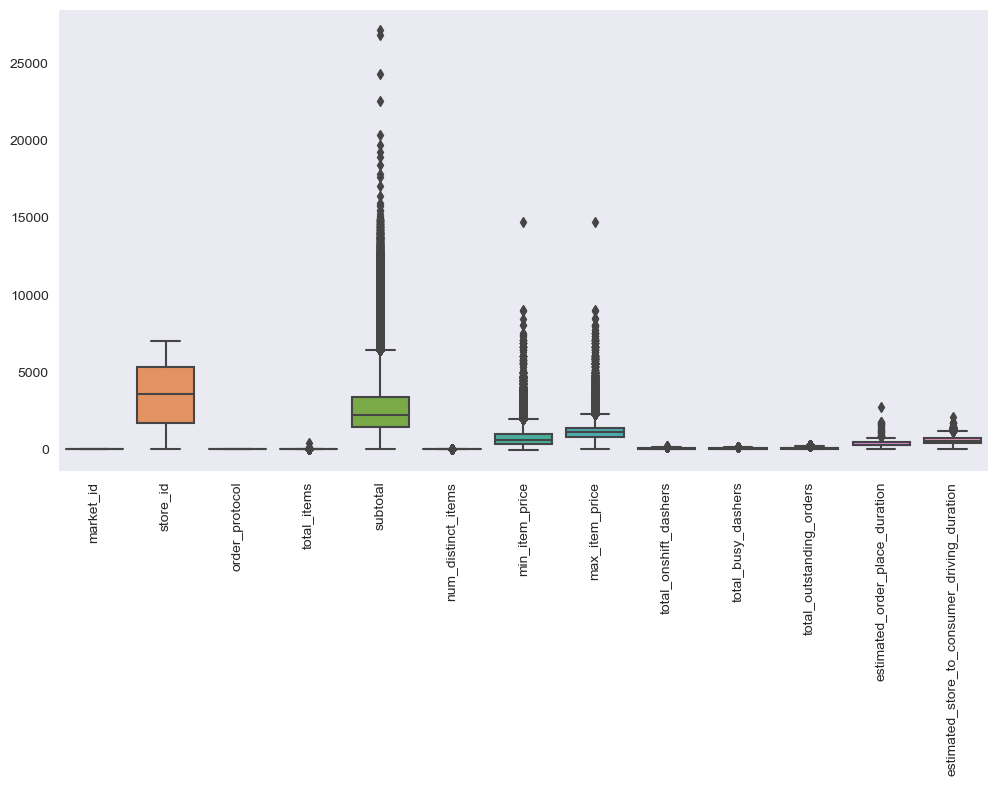

In [11]:
# Check for missing values
print(df.isnull().sum())

# Visualize boxplots for each column
figure=  plt.figure(figsize= (12, 6))
plt.xticks(rotation = 90)
sns.set_style('dark')
sns.boxplot(data=df) ## Checking for outliers


In [12]:
# Check for inconsistencies
inconsistencies = []
for col in df.columns:
    if df[col].nunique() < 2:
        inconsistencies.append(col) ## Checking for data inconsistencies
print('Inconcistent feature in the dataset:', inconsistencies)   

Inconcistent feature in the dataset: []


#
    Handling missing values

In [13]:
## get the colums with a missing values in numerical data:
df_na = df[[ 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'order_protocol', 'estimated_store_to_consumer_driving_duration' ]]

# Create KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Impute missing values
imputed_data = pd.DataFrame(imputer.fit_transform(df_na), columns=df_na.columns)

In [14]:
## mode avergae uses while we use categorical data:

store_id_unique = df["store_id"].unique().tolist()
store_id_and_category = {store_id: df[df.store_id == store_id].store_primary_category.mode()
                             for store_id in store_id_unique}

    ## Return primary store category from the dictionary
def fill(store_id):  
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
    
## create a new column in the dataset
df["NaN_free_store_primary_category"] = df.store_id.apply(fill) 

## drop the store id column
df = df.drop('store_primary_category', axis= 1)


In [15]:
### repalacing the old columns with the new ones
df[['total_onshift_dashers', 'total_busy_dashers', 
'total_outstanding_orders', 'order_protocol', 'estimated_store_to_consumer_driving_duration']] = imputed_data[['total_onshift_dashers','total_busy_dashers', 'total_outstanding_orders', 
                                                                                                                'order_protocol', 'estimated_store_to_consumer_driving_duration' ]]

## drop na values from actual delivery column


print('Total nan values in the dataset:\n\n', df.isnull().sum())

Total nan values in the dataset:

 market_id                                       987
created_at                                        0
actual_delivery_time                              7
store_id                                          0
order_protocol                                    0
total_items                                       0
subtotal                                          0
num_distinct_items                                0
min_item_price                                    0
max_item_price                                    0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_order_place_duration                    0
estimated_store_to_consumer_driving_duration      0
NaN_free_store_primary_category                 867
dtype: int64


##### Data Transformation
        Adding new features

In [17]:
df2 = df.copy()

In [18]:
## change cols to datetime
def to_date(col):
    col = pd.to_datetime(col)
    return col
df2[['created_at', 'actual_delivery_time']]  = df2[['created_at', 'actual_delivery_time']].apply(lambda x:to_date(x))

In [19]:
## Get the target variable
df2['actual_delivery_duration'] = df2['actual_delivery_time']-df2['created_at']
df2['actual_delivery_duration'] = df2['actual_delivery_duration'].dt.seconds

# new features/ predictive variable
df2['busy_to_onshift_dasher'] = round(df2['total_busy_dashers']/df2['total_onshift_dashers'], 2) ## getting the ratio of busy dasher over the total
df2["avg_price_per_item"] = df2["subtotal"] / df2["total_items"]                                  ## give the total price (before tax) of as item
df2['range_of_prices'] = df2['max_item_price'] - df2['min_item_price']                             ### price range 

In [20]:
df2 = df2.drop(columns=["total_onshift_dashers", "total_busy_dashers", "subtotal", "max_item_price", "min_item_price"])
df2.head()

,market_id,created_at,actual_delivery_time,store_id,order_protocol,total_items,num_distinct_items,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,NaN_free_store_primary_category,actual_delivery_duration,busy_to_onshift_dasher,avg_price_per_item,range_of_prices
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,1.0,4,4,21.0,446,861.0,american,3779.0,0.42,860.25,682
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,2.0,1,1,2.0,446,690.0,indian,4024.0,2.00,1900.00,0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1.0,1,1,0.0,446,690.0,indian,1781.0,0.00,1900.00,0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,1.0,6,5,2.0,446,289.0,indian,3075.0,1.00,1150.00,1200
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,1.0,3,3,9.0,446,650.0,indian,2390.0,1.00,1300.00,500


In [21]:
## Add Dummies to the market_id
market_dum_id = pd.get_dummies(df2['market_id'], prefix = ('market_id_'))

### Add dummies to the order category
order_dummies = pd.get_dummies(df2['order_protocol'], prefix = ('order_protocol_'))

## Add dummies to the store category
store_dummies = pd.get_dummies(df2["NaN_free_store_primary_category"], prefix = 'category_')

In [22]:
df2.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'order_protocol', 'total_items', 'num_distinct_items',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       'NaN_free_store_primary_category', 'actual_delivery_duration',
       'busy_to_onshift_dasher', 'avg_price_per_item', 'range_of_prices'],
      dtype='object')

In [23]:
## Merge the dummies to the main datasets inclusing the target variable
dff = df2.drop(columns = ['market_id', 'created_at', 'actual_delivery_time', 'store_id','order_protocol', 'NaN_free_store_primary_category'])

df_final = pd.concat([dff, market_dum_id, order_dummies, store_dummies], axis = 1)

***

### Data correlations
     Involves identifying relationships between variables in the data and analyzing their strength and direction.

<Axes: >

<Figure size 300x300 with 0 Axes>

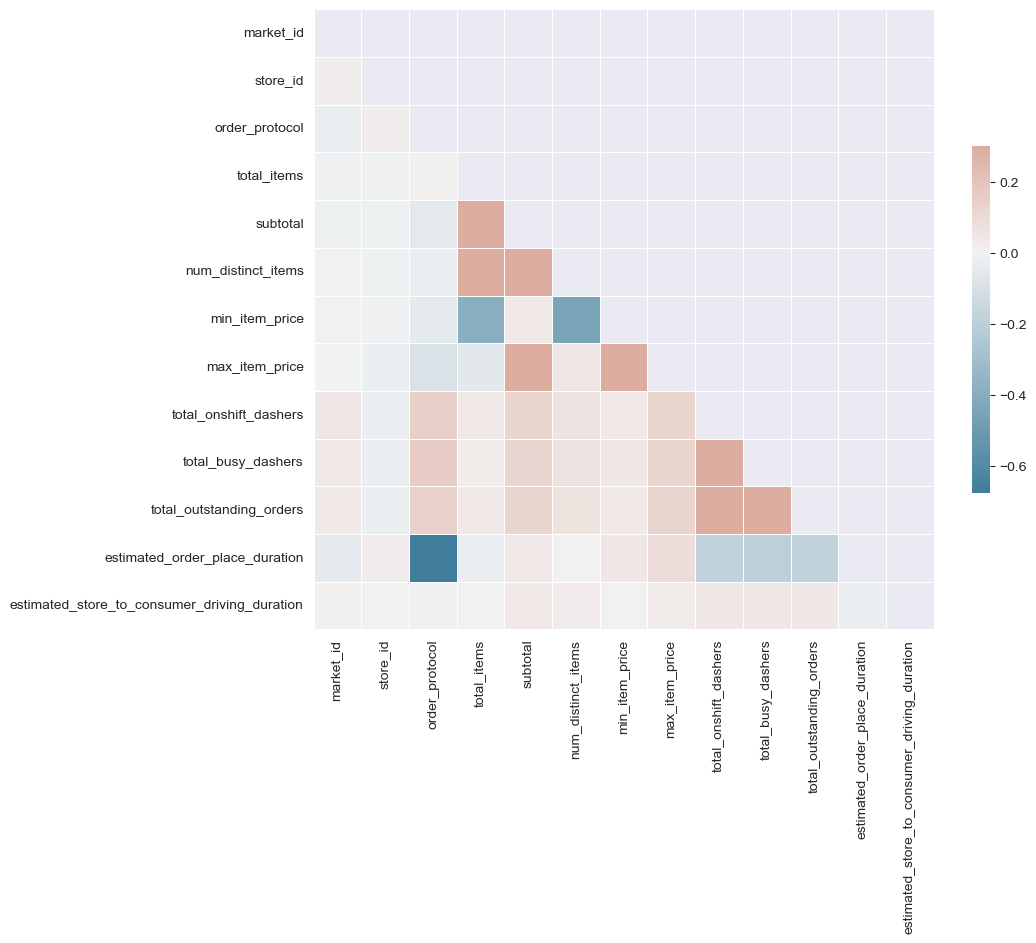

In [24]:
### the dataset before transformation
corr = df.corr() 
mask = np.triu(np.ones_like(corr, dtype=bool))  # helps get the Main Diagonal elements

# Set up the matplotlib figure
fig = plt.figure(figsize = (3,3))
fig, ax = plt.subplots(figsize=(10, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

***


### Feature importance
        Involves identifying the most important features in the data and their impact on the target variable.

##### Reduce Redundant and Collinear Features

<Axes: >

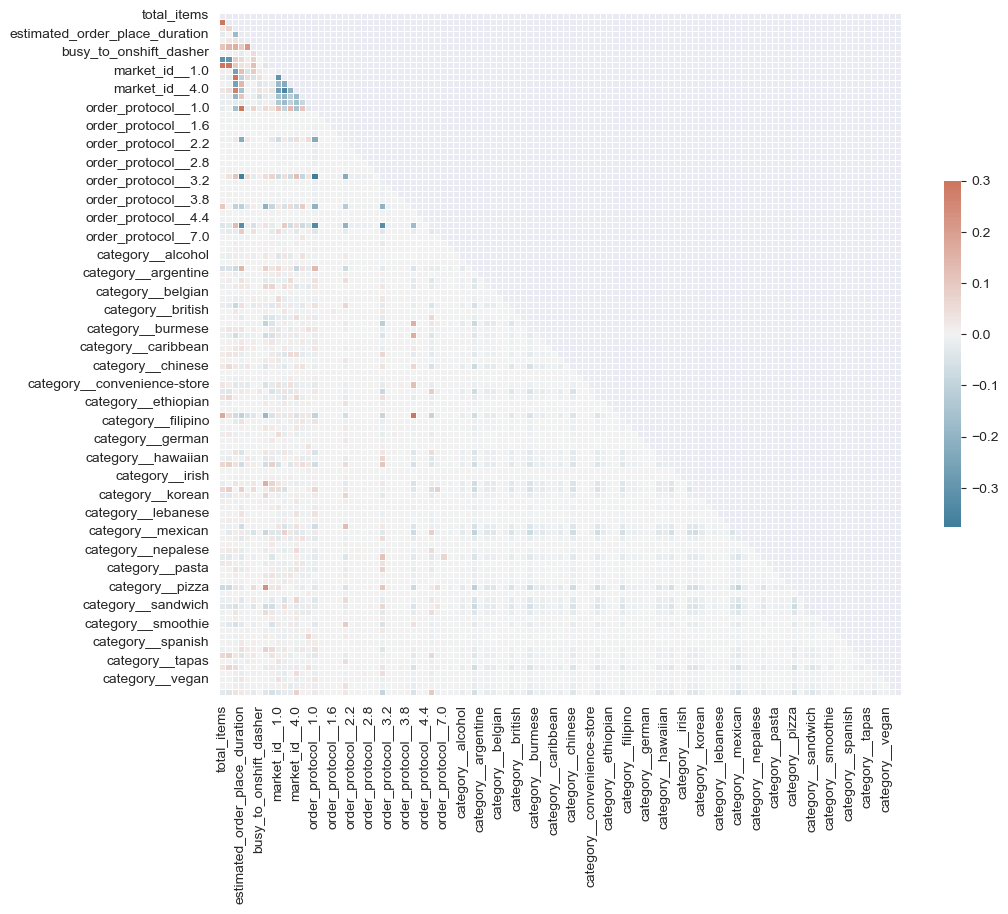

In [25]:
# Calculating correlation matrix in a dimesion of (100x100)

# Generate a mask for the upper triangle
corr = df_final.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))  # helps get the Main Diagonal elements
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
df_final.describe() ## check the overall look of the transformed dataset

,total_items,num_distinct_items,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration,busy_to_onshift_dasher,avg_price_per_item,range_of_prices,market_id__1.0,...,category__southern,category__spanish,category__steak,category__sushi,category__tapas,category__thai,category__turkish,category__vegan,category__vegetarian,category__vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197421.000000,193852.00,197428.000000,197428.000000,197428.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2.670791,57.501884,308.560179,545.356457,2862.304816,NaN,975.322997,473.370160,0.192663,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,2.666546,1.630255,50.883512,90.139653,219.135213,1180.916229,NaN,517.244403,516.059282,0.394391,...,0.028545,0.013689,0.073725,0.105701,0.027184,0.189384,0.034260,0.037834,0.064935,0.173122
min,1.000000,1.000000,-6.000000,0.000000,0.000000,101.000000,-inf,0.000000,-198.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,18.000000,251.000000,383.000000,2104.000000,0.83,647.666667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,42.000000,251.000000,544.000000,2660.000000,0.96,895.000000,370.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3.000000,81.400000,446.000000,702.000000,3381.000000,1.00,1195.000000,750.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,20.000000,285.000000,2715.000000,2088.000000,73282.000000,inf,14700.000000,8400.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- The summary of the dataset reveals the presence of infinity values, which need to be removed before conducting any further analysis.

In [27]:
# check infinity values with using numpy isfinite() function
np.where(np.any(~np.isfinite(df_final),axis=0) == True) ## the non infinite values

# replace inf values with nan to drop all nans
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

# drop NaN
df_final.dropna(how ='all', inplace=True)
df_final.shape

(197428, 111)

In [29]:
## Get diagonal and lower triangular pairs of the matrix
def get_redundant_pairs(df):  
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, len(cols)):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [30]:
## Sort correlations in the descending order and return n highest results
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations\n")
print(get_top_abs_correlations(df_final, 20))

Top Absolute Correlations

estimated_order_place_duration  order_protocol__1.0    0.895596
total_items                     num_distinct_items     0.763912
num_distinct_items              range_of_prices        0.499245
order_protocol__4.0             category__fast         0.496128
order_protocol__1.0             order_protocol__3.0    0.376742
estimated_order_place_duration  order_protocol__3.0    0.368259
market_id__2.0                  market_id__4.0         0.350511
total_items                     range_of_prices        0.334691
order_protocol__1.0             order_protocol__5.0    0.333046
order_protocol__3.0             order_protocol__5.0    0.327162
estimated_order_place_duration  order_protocol__5.0    0.325000
total_items                     avg_price_per_item     0.315521
market_id__1.0                  market_id__2.0         0.303789
total_outstanding_orders        market_id__2.0         0.296189
num_distinct_items              avg_price_per_item     0.293897
market_id__1.

- Based on the top absolute correlations, we can observe that there is a high correlation between num_distinct_items and market_id. Therefore, it is recommended to drop one of these features to avoid multicollinearity. Thus, we can drop num_distinct_items or market_id from the dataset.

#
     Drop market_id_dummies

In [31]:
df2.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'order_protocol', 'total_items', 'num_distinct_items',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       'NaN_free_store_primary_category', 'actual_delivery_duration',
       'busy_to_onshift_dasher', 'avg_price_per_item', 'range_of_prices'],
      dtype='object')

In [39]:
df_final["category__irish"].describe() ### dropped this column
df_final["category__indonesian"].describe()

count    197428.000000
mean          0.000010
std           0.003183
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: category__indonesian, dtype: float64

In [40]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
df_final1 = df2.drop(columns = ["created_at", "market_id", "store_id", "actual_delivery_time", 'num_distinct_items', 
                                        "NaN_free_store_primary_category", "order_protocol"])
# don't concat market id
df_final1 = pd.concat([df_final1, order_dummies , store_dummies], axis=1)

# drop highly correlated features
df_final1 = df_final1.drop(columns=["category__irish", "category__indonesian"])

# align dtype over dataset
df_final1 = df_final1.astype("float32")

# replace inf values with nan to drop all nans
df_final1.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final1.dropna(inplace=True)

In [42]:
print("Top Absolute Correlations\n")
print(get_top_abs_correlations(df_final1, 20))

Top Absolute Correlations

estimated_order_place_duration                order_protocol__1.0         0.896660
order_protocol__4.0                           category__fast              0.496343
order_protocol__1.0                           order_protocol__3.0         0.376633
estimated_order_place_duration                order_protocol__3.0         0.367458
total_items                                   range_of_prices             0.335427
order_protocol__1.0                           order_protocol__5.0         0.333257
order_protocol__3.0                           order_protocol__5.0         0.329467
estimated_order_place_duration                order_protocol__5.0         0.324580
total_items                                   avg_price_per_item          0.315079
avg_price_per_item                            category__pizza             0.232446
order_protocol__1.0                           order_protocol__2.0         0.230669
order_protocol__2.0                           order_protocol

- Based on the top absolute correlations, we can observe that there is a high correlation between order_protocols. Therefore, it is recommended to drop one of these features to avoid multicollinearity

#
        Drop order_protocol_dummies

In [43]:
### Then drop the order protocol dummies as there is a large correlation 
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol

df_final2 = df2.drop(columns = ["created_at", "market_id", "store_id", "actual_delivery_time", 'num_distinct_items', 
                                        "NaN_free_store_primary_category", "order_protocol"])
# don't concat market id
df_final2 = pd.concat([df_final2, store_dummies], axis=1)
# drop highly correlated features
df_final2 = df_final2.drop(columns=["category__irish", "category__indonesian"])
# align dtype over dataset
df_final2 = df_final2.astype("float32")
# replace inf values with nan to drop all nans
df_final2.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final2.dropna(inplace=True)

In [44]:
print("Top Absolute Correlations\n")
print(get_top_abs_correlations(df_final2, 20))

Top Absolute Correlations

total_items                                   range_of_prices                   0.335427
                                              avg_price_per_item                0.315079
avg_price_per_item                            category__pizza                   0.232446
estimated_store_to_consumer_driving_duration  actual_delivery_duration          0.221315
avg_price_per_item                            category__fast                    0.180453
total_items                                   category__fast                    0.178247
total_outstanding_orders                      actual_delivery_duration          0.176015
                                              estimated_order_place_duration    0.175181
avg_price_per_item                            category__italian                 0.156885
estimated_order_place_duration                category__american                0.146493
actual_delivery_duration                      range_of_prices                   0.1

-  Variance Inflation Factor (VIF) determines the strength of the correlation between the independent variables.

In [45]:
## Compute VIF score using variance_inflation_factor() function
def compute_vif(features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df_final2[features].values, i) for i in range(len(features))] 
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [46]:
# apply VIF computation to all predicting columns: drop the target variable :
features = df_final2.drop(columns=["actual_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category__alcohol-plus-food,1.000203
1,category__chocolate,1.000329
2,category__belgian,1.000410
3,category__african,1.002845
4,category__european,1.003020
...,...,...
74,category__american,4.418398
75,avg_price_per_item,5.952657
76,busy_to_onshift_dasher,6.765846
77,estimated_store_to_consumer_driving_duration,7.127447


***

In [ ]:
# perform stepwise feature selection based on VIF values
while True:
    vif_data = compute_vif(features)
    if len(vif_data[vif_data.VIF > 20]) == 0:
        break
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)

# store selected features in a list
selected_features = vif_data.feature.tolist()

***

In [67]:
## Drop the columns with the higher VIF score: when it is greater that 20

multicollinearity = True
while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data 

I will remove estimated_order_place_duration


,feature,VIF
0,category__alcohol-plus-food,1.000169
1,category__belgian,1.000175
2,category__chocolate,1.000219
3,category__african,1.001475
4,category__european,1.002002
...,...,...
73,category__pizza,3.071595
74,total_items,3.150659
75,avg_price_per_item,5.909139
76,busy_to_onshift_dasher,6.763789


#####  Data dimensionality
         Involves analyzing the number of features and their relevance in the analysis/ feature selection

In [68]:
# selected features are selected in multicollinearity check part
X = df_final2[selected_features]
y = df_final2["actual_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

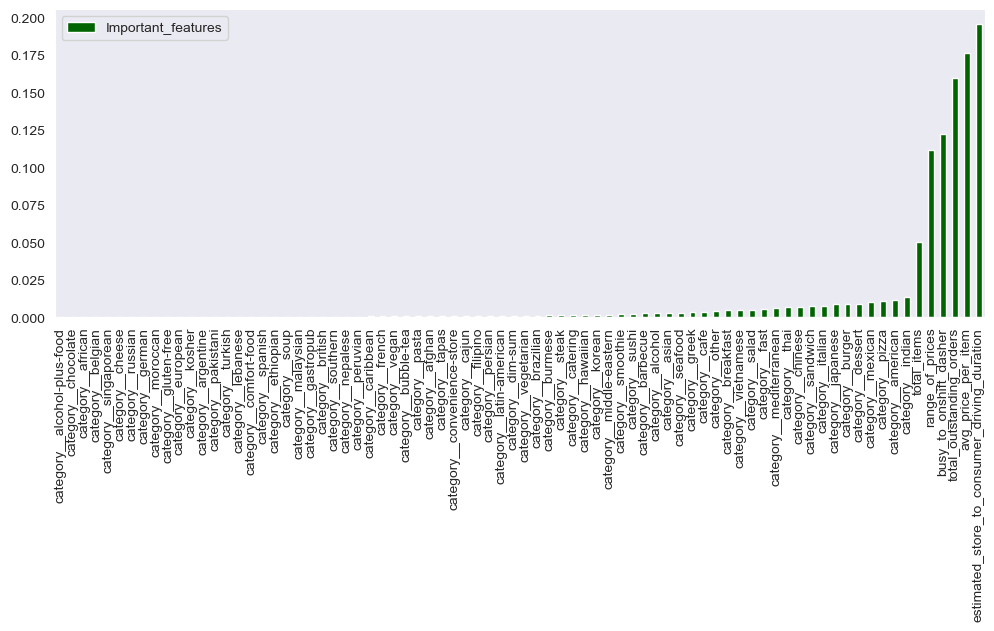

In [71]:
# create a random forest regressor with a fixed random seed and train in the training data
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

# create an empty dictionary to store the feature importance scores
feat_dic = {}

# loop over the feature names and their importance scores
for feature, importance in zip(X.columns, forest.feature_importances_):
    # add the feature name and importance score to the dictionary
    feat_dic[feature] = importance

# convert the dictionary to a pandas DataFrame
importances = pd.DataFrame.from_dict(feat_dic, orient='index').rename(columns={0: 'Important_features'})

# sort the DataFrame by feature importance and create a bar chart
importances.sort_values(by='Important_features').plot(kind='bar', rot=90, figsize=(12,4), color='darkgreen')
plt.show()

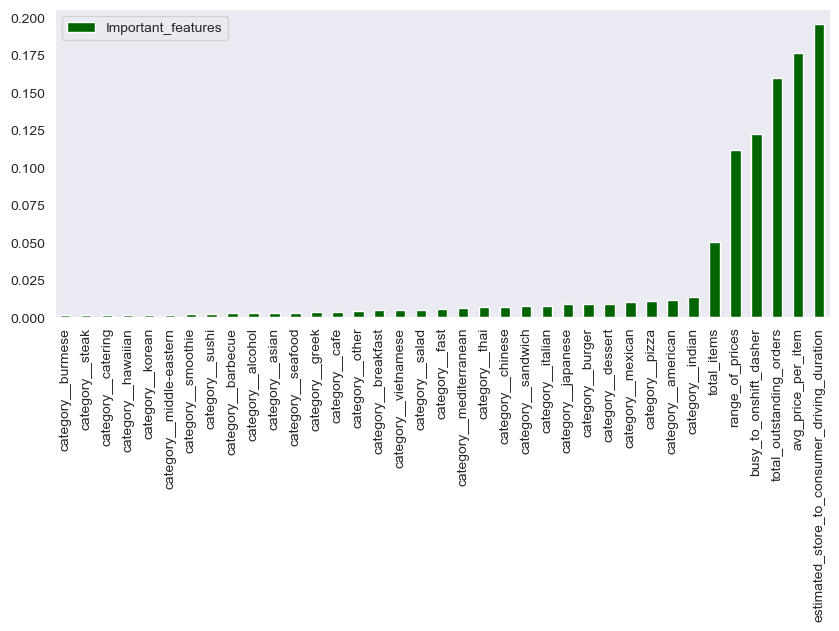

In [73]:
# check the most important ones
importances.sort_values(by='Important_features')[-37:].plot( kind='bar', rot=90, figsize=(10,4) , color = 'darkgreen')
plt.show()

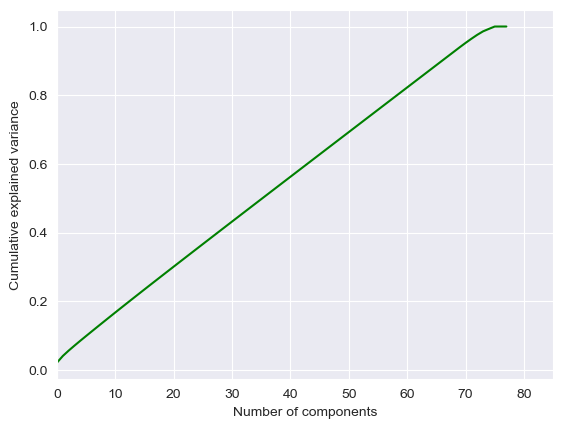

In [74]:
# apply PCA to see feature contributions
X_Train = X_train.values
X_Train = np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
sns.set_style('darkgrid')
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'green')
plt.xlim(0,85)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

Although PCA indicates that we require 60 representative features to explain 80% of the dataset, this conclusion renders the PCA transformation unnecessary since we already possess 80 features, and can select the most significant ones based on their importance. However, if PCA indicated that it could account for most of the variance with just 10 features - a considerable reduction - then we would proceed with it.

### Machine Learning
        Feature scaling

In [81]:
## Apply the selected scaler to features and target variables
def scale(scaler, X, y):
    X_scaler = scaler
    X_scaler.fit(X = X , y = y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [82]:
### scaling out predictive and target variable
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

# train-test split after scaling
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42)

#
    Inverse Transform for Metric Comparison


> Because we applied a scaler to the training data, any predictions we make for the test data will also be scaled. Therefore, to evaluate the performance of our model in terms of seconds, we must apply the inverse transformation to our predictions. We will use Root Mean Squared Error (RMSE) as our error metric because it is more sensitive to high error values compared to Mean Squared Error (MSE) or Mean Absolute Error (MAE). 
- Our rationale for this is that we assume consumer patience with delayed delivery decreases exponentially with time. Therefore, it is crucial to minimize the impact of high error values that could potentially result in significant delivery delays.

In [75]:
def rmse_with_inv_transf(scaler, y_test, y_pred_scaled, model_name):
    ### convert the scaled error to real error by inverse_transforming 
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)) 
    ## get the rmse without squaring
    rmse_error = mean_squared_error(y_test, y_predict[:, 0], squared = False)
    print(f' Error: "''{}'.format(rmse_error)+" in " + model_name)
    return rmse_error, y_predict

In [76]:
# create a generic function: that works with multiple ML models
def make_regression(X_train, y_train, X_test, y_test, model, model_name, all_good = False):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_train)
    train_err = mean_squared_error(y_train, y_predict, squared = False)
    y_predict = model.predict(X_test)
    test_err =  mean_squared_error(y_test, y_predict, squared = False)
    if all_good:
        print("Train error =" '{}'.format(train_err) + " in " + model_name)
        print("Test error ="'{}'.format(test_err) + " in " + model_name)
    trained_model = model
    
    return trained_model, y_predict, train_err, test_err


In [77]:
#from xgboost import XGBregressor
#from lightgbm import LGBMregressor
#from sklearn.neutral_networking import MLPRegressor
from sklearn import tree
from sklearn import neighbors
from sklearn import linear_model

In [79]:
pred_dict = {
    "Regression_model":[],
    "Feature_set":[],
    "Scaler_name":[],
    "RMSE":[]
}

regression_models = {
    "Ridge": linear_model.Ridge(),
    "Decision_tree": tree.DecisionTreeRegressor(max_depth = 6),
    "Random_forest": RandomForestRegressor()
}

feature_sets = {
    "whole_set":X.columns.tolist(),
    "selected_feat_40":importances.sort_values(by = 'Important_features')[-40:].index.tolist(),
    "selected_feat_20":importances.sort_values(by = 'Important_features')[-20:].index.tolist()
}

scaler = {
    "Standard_scalar": StandardScaler(),
    "MinMax_scalar": MinMaxScaler(),
    "No_scaling" : None
}

In [84]:
### exploring the errors in each model
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scaler.keys():
        print(f"------Scaled with {scaler_name} ------included features are {feature_set_name}")
        for model_name in regression_models.keys():
            if scaler_name == 'No_scaling':
                X = df_final2[feature_set]
                y = df_final2['actual_delivery_duration']
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, all_good =True)
            else:
            
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scaler[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, all_good=False)
                rmse_error, y_predict = rmse_with_inv_transf(y_scaler, y_test, y_predict_scaled, model_name)
                          
           
                
            pred_dict["Regression_model"].append(model_name)
            pred_dict["Feature_set"].append(feature_set_name)
            pred_dict["Scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

------Scaled with Standard_scalar ------included features are whole_set
 Error: "1084.021728515625 in Ridge
 Error: "1087.9969457905393 in Decision_tree
 Error: "1079.4610751795012 in Random_forest
------Scaled with MinMax_scalar ------included features are whole_set
 Error: "1084.555419921875 in Ridge
 Error: "1087.9969455292578 in Decision_tree
 Error: "1078.79486170399 in Random_forest
------Scaled with No_scaling ------included features are whole_set
Train error =1107.9844970703125 in Ridge
Test error =1084.02490234375 in Ridge
Train error =1103.2443687052466 in Decision_tree
Test error =1087.9969459787421 in Decision_tree
Train error =412.0424080697666 in Random_forest
Test error =1079.237087684766 in Random_forest
------Scaled with Standard_scalar ------included features are selected_feat_40
 Error: "1084.736572265625 in Ridge
 Error: "1087.9969457905393 in Decision_tree
 Error: "1078.4486984287355 in Random_forest
------Scaled with MinMax_scalar ------included features are selec

##
    Findings from the models

In [85]:
### over view how models predicted
pred_df = pd.DataFrame(pred_dict)
pred_df.head()

,Regression_model,Feature_set,Scaler_name,RMSE
0,Ridge,whole_set,Standard_scalar,1084.021729
1,Decision_tree,whole_set,Standard_scalar,1087.996946
2,Random_forest,whole_set,Standard_scalar,1078.481881
3,Ridge,whole_set,MinMax_scalar,1084.555420
4,Decision_tree,whole_set,MinMax_scalar,1087.996946


<Axes: >

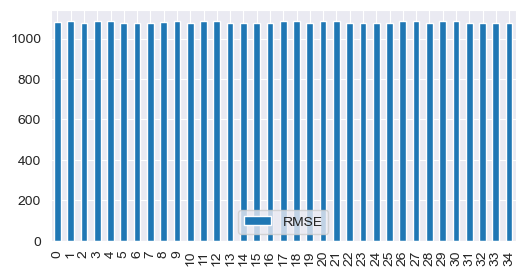

In [95]:
pred_df.plot(kind='bar', figsize=(6,3))


- It is clear that there is high errors across all of our models.
- Our models have informed us that not scaling the data positively impacts performance.
- Possible to use any scaler since it doesn't significantly affect performance.
- Initial decrease in the number of training features slightly improved performance, but further reduction had a marginal effect.
- onsidering all factors, it is idea to use 40 features in our final model.
- Error rates are the most significant factor to consider when evaluating our model performances. They help us determine the effectiveness of the model and the level of accuracy in our predictions.

In [96]:
st_s = pred_df[pred_df['Scaler_name'] == 'Standard_scalar']
Feat_40_stan_sc = st_s[st_s['Feature_set'] == 'selected_feat_40']
Feat_40_stan_sc

,Regression_model,Feature_set,Scaler_name,RMSE
17,Ridge,selected_feat_40,Standard_scalar,1084.736572
18,Decision_tree,selected_feat_40,Standard_scalar,1087.996946
19,Random_forest,selected_feat_40,Standard_scalar,1078.448698


- From the findings --> RandomForest got the best result. Then we peoceed with that model

##
    Random Forest model

In [99]:
pred_dict = {
    "Regression_model":[],
    "Feature_set":[],
    "Scaler_name":[],
    "RMSE":[]
}
regression_models = {
    "Random_forest": RandomForestRegressor(),
}
feature_sets = {
    "selected_feat_40":importances.sort_values(by = 'Important_features')[-40:].index.tolist(),   
}
scaler = {
    "Standard_scalar": StandardScaler(),
}

In [100]:
### exploring the errors in each model
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scaler.keys():
        print(f"------Scaled with {scaler_name} ------included features are {feature_set_name}")
        for model_name in regression_models.keys():
            X = df_final2[feature_set]
            y = df_final2['actual_delivery_duration']
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scaler[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, all_good=False)
            rmse_error, y_predict = rmse_with_inv_transf(y_scaler, y_test, y_predict_scaled, model_name)
            
            pred_dict["Regression_model"].append(model_name)
            pred_dict["Feature_set"].append(feature_set_name)
            pred_dict["Scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

------Scaled with Standard_scalar ------included features are selected_feat_40
 Error: "1078.2874107990601 in Random_forest


In [105]:
## true and the predicted values
y_test = np.array(y_test)
df_p = pd.DataFrame({'True Labels': y_test, 'Predicted Labels': pd.Series(np.ravel(y_predict))})
df_p.head()

,True Labels,Predicted Labels
0,2940.0,3255.240000
1,1368.0,2549.519997
2,2289.0,3312.290015
3,1908.0,2324.280023
4,2404.0,3209.600010


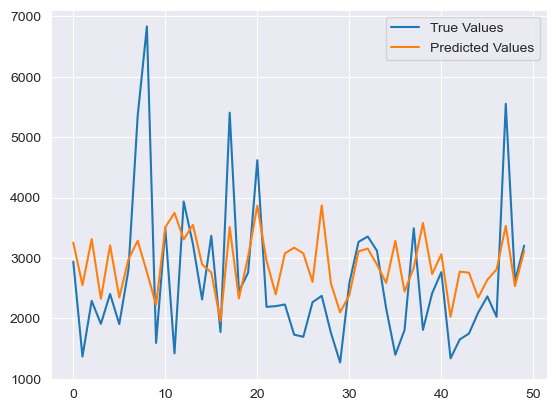

In [110]:

plt.plot(df_p['True Labels'].head(50), label='True Values')
plt.plot(df_p['Predicted Labels'].head(50), label='Predicted Values')
plt.legend()
plt.show()

***

### questions:

#### Are there particular restaurant cuisines (store_primary_category) that tend to have longer or shorter delivery times, and why? 